<a href="https://colab.research.google.com/github/hsqsh/comp551/blob/main/c1MLE_BayesianInference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/MLE_BayesianInference.ipynb)

# Maximum Likelihood

In [35]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
np.random.seed(1234)

Lets assume that a thumbtack has a probability $0 < \theta^* < 1$ of _heads_ .
We use a **Bernoulli** distribution [$\mathrm{Bernoulli}(x | \theta) = \theta^{x} (1-\theta)^{1-x}$] to model this

In [36]:
#Function to compute parametric probability mass function
#If you pass arrays or broadcastable arrays it computes the elementwise bernoulli probability mass
Bernoulli = lambda theta,x: theta**x * (1-theta)**(1-x)
theta_star = .4
Bernoulli(theta_star, 1)

0.4

The **likelihood** of $\theta^* = \theta$ is
$$L(\theta) = \prod_{n=1}^{10} \mathrm{Bernoulli}(\theta, x^{(n)})$$
Note that this is a function of $\theta$, it is not a probability distribution, so it doesn't sum to 1.

In [37]:
n = 10                                                              #number of random samples you want to consider
xn = np.random.rand(n) < theta_star                                 #Generates n element boolean array where elements are True with probability theta_star and otherwise False
xn = xn.astype(int)

print(xn.shape)

(10,)


In [38]:
xn[None,:].shape

(1, 10)

In [39]:
theta_vals = np.linspace(0,1,100)[:,None]
theta_vals.shape

(100, 1)

observation [1 0 0 0 1 0 0 1 0 0]


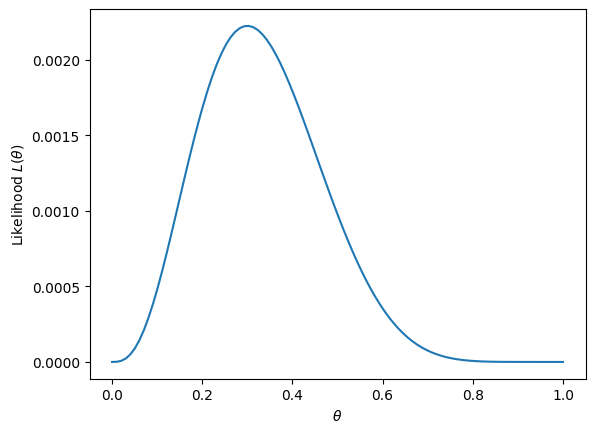

In [40]:
n = 10                                                              #number of random samples you want to consider
xn = np.random.rand(n) < theta_star                                 #Generates n element boolean array where elements are True with probability theta_star and otherwise False
xn = xn.astype(int)                                                 #to change the boolean array to intergers [0:False, 1:True]
print("observation {}".format(xn))
#Function to compute the log likelihood
#Note that you can either pass this function a scalar(always broadcastable) theta or a broadcastable(in data axis) theta to get likelihood value or values
#Also note that we added an extra dimension in xn to broadcast it along theta dimension
L = lambda theta: np.prod(Bernoulli(theta, xn[None,:]), axis=-1)
#we generate 100 evenly placed values of theta from 0 to 1
theta_vals = np.linspace(0,1,100)[:, None]                         #Note that we made the array broadcastable by adding an extra dimension for data
plt.plot(theta_vals, L(theta_vals), '-')
plt.xlabel(r"$\theta$")
plt.ylabel(r"Likelihood $L(\theta)$")
#plt.title(r"likelihood function Bernoulli("+str(xn.astype(int))+r"$|\theta)$")
plt.show()

**maximum likelihood** method for learning a probabilistic model picks $\theta$ that maximizes $L(\theta)$ for a given set of observations $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$.
For _Bernoulli_ dist. max. likelihood estimate is the $\widehat{\theta} = \frac{1}{N} \sum_n x^{(n)}$, corresponding to the peak of the likelihood plot. The value of the likelihood shrinks exponentially as we increase the number of observations $N$ -- try `N=100`.
A more numerically stable value with the same _maximum_ is the **log-likelihood** $\ell(\theta) = \log(L(\theta))$. It is also customary to minimize the _negative log-likelihood_ (NLL).
Let's plot NLL for different $N$ -- as we increase our data-points the ML estimate often gets better.

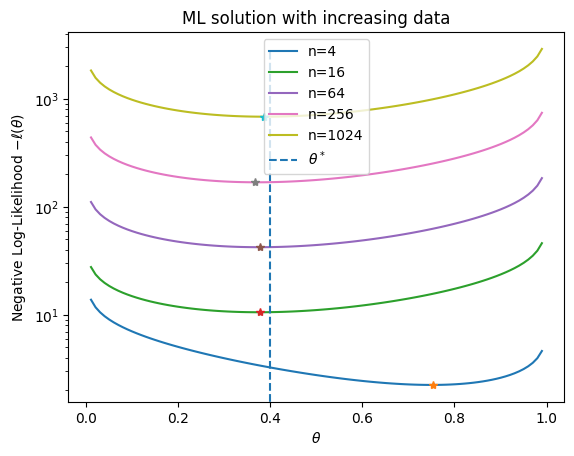

In [41]:
#Generates 2^12 element boolean array where elements are True with probability theta_star and otherwise False
xn_max = np.random.rand(2**12) < theta_star
for r in range(1,6):
    n = 4**r              #number of data samples for r-th iteration
    xn = xn_max[:n]       #slice them from the total samples generated
    #Function to compute the log likelihood (Implementation exactly similar to the likelihood function)
    ll = lambda theta: np.sum(np.log(Bernoulli(theta, xn[None,:])), axis=-1)
    theta_vals = np.linspace(.01,.99,100)[:, None]
    ll_vals = -ll(theta_vals)
    #Plot the log likelihood values
    plt.plot(theta_vals, ll_vals, label="n="+str(n))
    max_ind = np.argmin(ll_vals)                            #Stores the theta corresponding to minimum log likelihood
    plt.plot(theta_vals[max_ind], ll_vals[max_ind], '*')
#to get the horizontal line for theta
plt.plot([theta_star,theta_star], [0,ll_vals.max()], '--', label=r"$\theta^*$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"Negative Log-Likelihood $-\ell(\theta)$")
plt.yscale("log")
plt.title("ML solution with increasing data")
plt.legend()
plt.show()

ML estimate does not reflect our uncertainty. We could estimate $\widehat{\theta} = .2$ by observing 2 heads in 10 trials or 200 heads in 1000 trials. A Bayesian approach solves this problem.

# Bayesian Inference

In the Bayesian setting, probabilities reflect our uncertainty. We start by having a **prior** belief $p(\theta)$ about the right model of the world.
We then make observations $\mathcal{D} = \{x^{(1)}, \ldots, x^{(N)}\}$, with likelihood $p(\mathcal{D} \mid \theta)$, and update our belief to a **poseterior belief** $p(\theta \mid \mathcal{D})$. **Bayes rule** lets us calculate this posterior probability:
$$ p(\theta \mid \mathcal{D}) = \frac{p(\theta) p(\mathcal{D} \mid \theta)}{p(\mathcal{D})} $$
The denominator $p(\mathcal{D}) = \int_\theta p(\theta) p(\mathcal{D} \mid \theta) \mathrm{d}\theta$, called _evidence_,  makes sure that the posterior sums to one.

### Conjugate Priors
When using Bayes rule, ideally we want the prior and posterior to belong to the same family of distributions. For example, this way we can update our belief as we observe more data using successive applications of Bayes rule. Certain pairing of the likelihood family of distribution $p(x^{(n)} \mid \theta)$ and the prior enable this behaviour. When this is true we say
that the prior is **conjugate** to the likelihood.

#### Beta-Bernoulli conjugate pair
Looking close at Bernoulli $\mathrm{Bernoulli}(x | \theta) = \theta^{x} (1-\theta)^{1-x}$, its conjugate prior $p(\theta)$ should have $\theta$ and $1-\theta$ as the basis in an exponentiation and the parameters of the prior should appear in the exponent. Beta distribution has this exact form
$$\mathrm{Beta}(\theta \mid \alpha, \beta) \propto \theta^{\alpha-1} (1-\theta)^{\beta - 1}$$
Here, $\propto$ sign means that we have dropped the normalization $B(\alpha,\beta)$, called the Beta function (`beta(a,b)` below). Lets plot Beta distribution for different values of $\alpha, \beta > 0$:

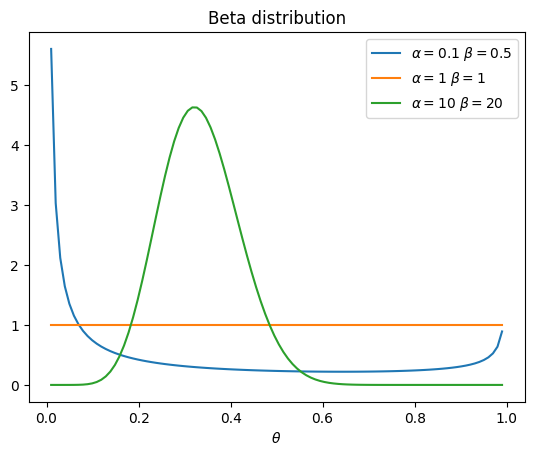

In [42]:
from scipy.special import beta                                      #we import beta function from scipy
#Function to compute probability density function of beta distribution parameterized by a and b
Beta = lambda theta,a,b: ((theta**(a-1))*((1-theta)**(b-1)))/beta(a,b)
#Plot the distribution for different values of a and b
for a,b in [(.1,.5), (1,1), (10,20)]:
    theta_vals = np.linspace(.01,.99,100)
    p_vals = Beta(theta_vals, a, b)
    plt.plot(theta_vals, p_vals, label=r"$\alpha=$"+str(a)+r" $\beta=$"+str(b))
plt.xlabel(r"$\theta$")
plt.title("Beta distribution")
plt.legend()
plt.show()

Lets see what the posterior looks like after observing a single instance $x \in \{0,1\}$:
$$\mathrm{Beta}(\theta|\alpha, \beta) \mathrm{Bernoulli}(x| \theta) \propto \theta^{\alpha + x - 1} (1-\theta)^{\beta + (1-x) - 1} \propto \mathrm{Beta}(\theta \mid \alpha+x, \beta+(1-x))$$

Therefore, observing a head will increase $\alpha$ by one, and observing a tail will increase $\beta$ in the posterior by the same amount. Observing $n_h$ heads and $n = n_h$ tails in a dataset will lead to posterior $\mathrm{Beta}(\theta| \alpha+n_h, \beta+n - n_h)$.

Another distribution with a similar form as Bernoulli that has Beta distribution as a conjugate prior is the Binomial distribution. Note that the probability of observing a specific sequence $x^{(1)}, \ldots, x^{(n)}$, only depends on the total _number of heads ($nh$) and tails ($nt=N-nh$)_ in that sequence.
**Binomial** distribution gives the probability of all such outcomes:
$$\mathrm{Binomial}(n, n_h, \theta) = {n \choose n_h} \theta^{n_h} (1-\theta)^{n-n_h}$$

Now, let's go back to the example where we increase the number of observations $N$ and see how this affects our posterior belief about the value of $\theta^*$. We start from a uniform prior over $\theta$ corresponding to $\alpha=\beta=10$.

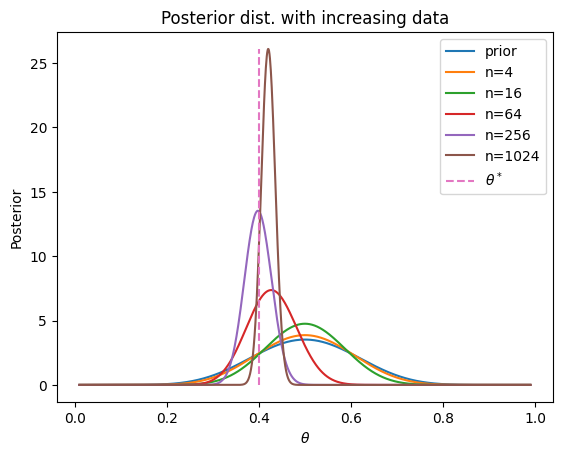

In [43]:
xn_max = np.random.rand(2**12) < theta_star
a0, b0 = 10, 10
theta_vals = np.linspace(.01,.99,1000)[:, None]
posterior = Beta(theta_vals, a0, b0)              #get the prior distribution
plt.plot(theta_vals, posterior , label="prior")
for r in range(1,6):
    n = 4**r
    xn = xn_max[:n]
    nh = np.sum(xn)                                           #number of heads out of n data samples
    posterior = Beta(theta_vals, a0+nh, b0+n-nh)              #update the posterior based on the number of samples
    plt.plot(theta_vals, posterior , label="n="+str(n))

plt.plot([theta_star,theta_star], [0,posterior.max()], '--', label=r"$\theta^*$")
plt.xlabel(r"$\theta$")
plt.ylabel(r"Posterior")
plt.title("Posterior dist. with increasing data")
plt.legend()
plt.show()

Note that the posterior becomes more peaked around $\theta^*$, while also reflecting our uncertainty about the model.
### Posterior predictive
The purpose of learning a model is to make predictions. When we have a distribution over model parameters, we can look at the expected outcome -- i.e., using weighted average of predictions.
When using posterior distribution $p(\theta| \mathcal{D})$ for this purpose, the _expected outcome_ is called the _posterior predictive_:
$$p(x | \mathcal{D}) = \int_\theta p(\theta | \mathcal{D}) p(x | \theta) \mathrm{d} \theta$$

For Beta-Bernoulli this is the same as the posterior mean
$$p(x | \mathcal{D}) = \int_\theta \mathrm{Beta}(\theta | \alpha+ n_h, \beta+n-n_h)  \theta \mathrm{d} \theta = \frac{B(\alpha, \beta)}{B(\alpha+n_h,\beta)} = \frac{\alpha + n_h}{\alpha+\beta+n}.$$
In practical terms, the posterior predictive distribution for the probability of seeing a head smoothens the maximum-likelihood based estimate by adding pseudo-counts $\alpha_0, \beta_0$. In the context of Bernoulli (Binomial) and Multinomial distributions this smoothed prediction is also known as **Laplace smoothing**.

### Maximum a Posteriori (MAP) inference

In many applications calculating the posterior distribution is not easy.
A cheap alternative is to calculate the mode (maximum) of the posterior distribution:$$ \max_\theta p(\theta| x) = \max_\theta p(\theta) p(x | \theta) $$





This expression has the same maximum as the logarithm of the posterior: $\log p(\theta| x) = \log  p(\theta) + \ell(\theta)$, where the second term is the log-likelihood.
Therefore MAP inference simply adds a _regularizer_ term to the log-likelihood that takes into account our prior belief about the model.